# Machine Learning Pipeline   
### *An Implementation of Financial Distress Prediction*  

*Yeol Ye   
University of Chicago  
ziyuye@uchicago.edu*

## Phase 1: Data Preparation

In [1]:
import os
import sys
import warnings
sys.path.append('../code/')
warnings.filterwarnings('ignore')

import prep
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
data_file = 'credit-data.csv'
df_file = 'df.pkl'
dict_file='Data Dictionary.xls'
cat_list = ['PersonID', 'zipcode']
target_name = 'SeriousDlqin2yrs'

prep.data_transforming(data_file, df_file, dict_file='Data Dictionary.xls')
df = prep.data_loading(df_file)

In [3]:
df.describe()

PersonID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count   41016.000000      41016.000000                           41016.00000   
mean   115800.154598          0.161400                               6.37587   
std     28112.723511          0.367904                             221.61895   
min        22.000000          0.000000                               0.00000   
25%    106539.750000          0.000000                               0.03431   
50%    119901.500000          0.000000                               0.18973   
75%    134698.250000          0.000000                               0.66716   
max    149999.000000          1.000000                           22000.00000   

                age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  41016.000000                          41016.000000   41016.000000   
mean      51.683489                              0.589233     331.458137   
std       14.746880                              5.205628    1296.109695   
min       21.000000                              0.000000       0.000000   
25%       41.000000                              0.000000       0.176375   
50%       51.000000                              0.000000       0.369736   
75%       62.000000                              0.000000       0.866471   
max      109.000000                             98.000000  106885.000000   

       MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
count   4.101600e+04                     41016.000000   
mean    6.320623e+03                         8.403477   
std     1.208056e+04                         5.207324   
min     0.000000e+00                         0.000000   
25%     3.800000e+03                         5.000000   
50%     5.250000e+03                         8.000000   
75%     7.245500e+03                        11.000000   
max     1.794060e+06                        56.000000   

       NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
count             41016.000000                  41016.000000   
mean                  0.419592                      1.008801   
std                   5.190382                      1.153826   
min                   0.000000                      0.000000   
25%                   0.000000                      0.000000   
50%                   0.000000                      1.000000   
75%                   0.000000                      2.000000   
max                  98.000000                     32.000000   

       NumberOfTime60-89DaysPastDueNotWorse  NumberOfDependents  
count                          41016.000000        41016.000000  
mean                               0.371587            0.753681  
std                                5.169641            1.113639  
min                                0.000000            0.000000  
25%                                0.000000            0.000000  
50%                                0.000000            0.000000  
75%                                0.000000            1.000000  
max                               98.000000           13.000000

In [69]:
target, features = prep.target_features_split(target_name, df)
cat, numeric = prep.num_cat_split(features, cat_list)

## Phase 2: Data Exploration

In [148]:
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

import explore

### 2.1 Check the Distribution for the Target

<IPython.core.display.Javascript object>


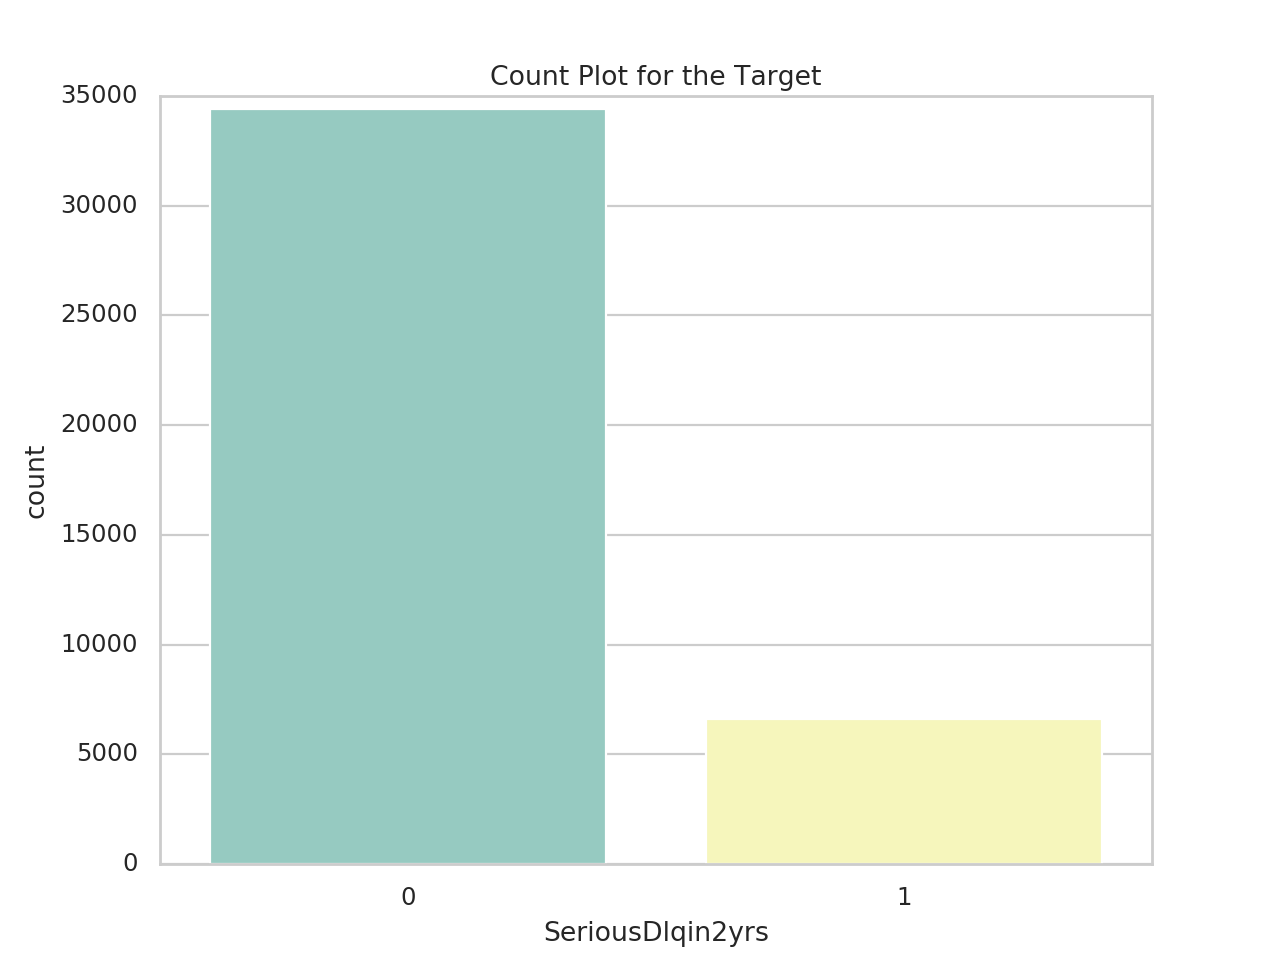

In [205]:
explore.count_plot('SeriousDlqin2yrs', target, 'Count Plot for the Target')

### 2.2 Check the Distribution for the Categorical Column of Features

<IPython.core.display.Javascript object>


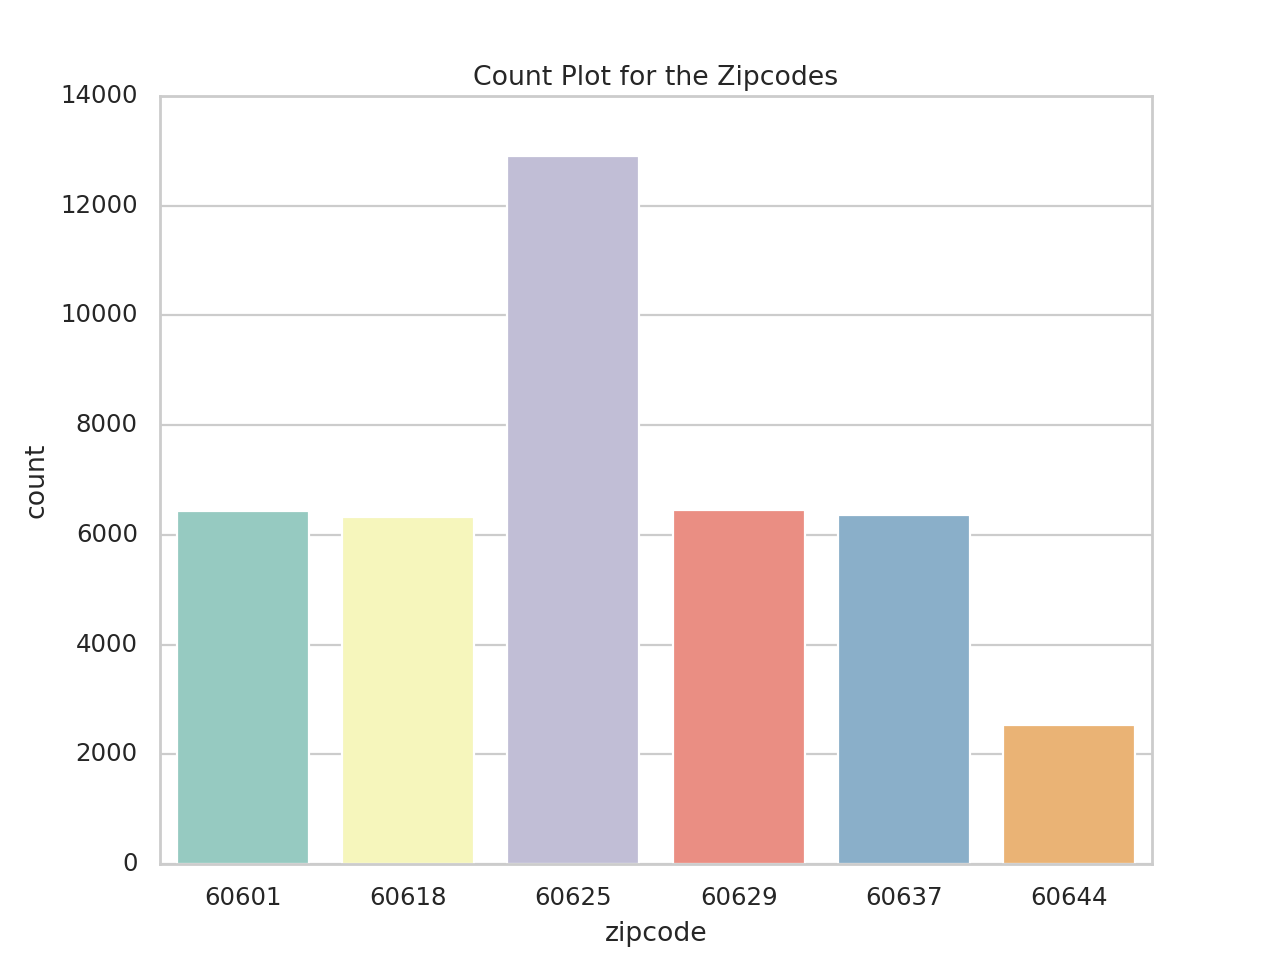

In [206]:
explore.count_plot('zipcode', features, 'Count Plot for the Zipcodes')

### 2.3 Check the Distribution and Outliers for Numeric Data

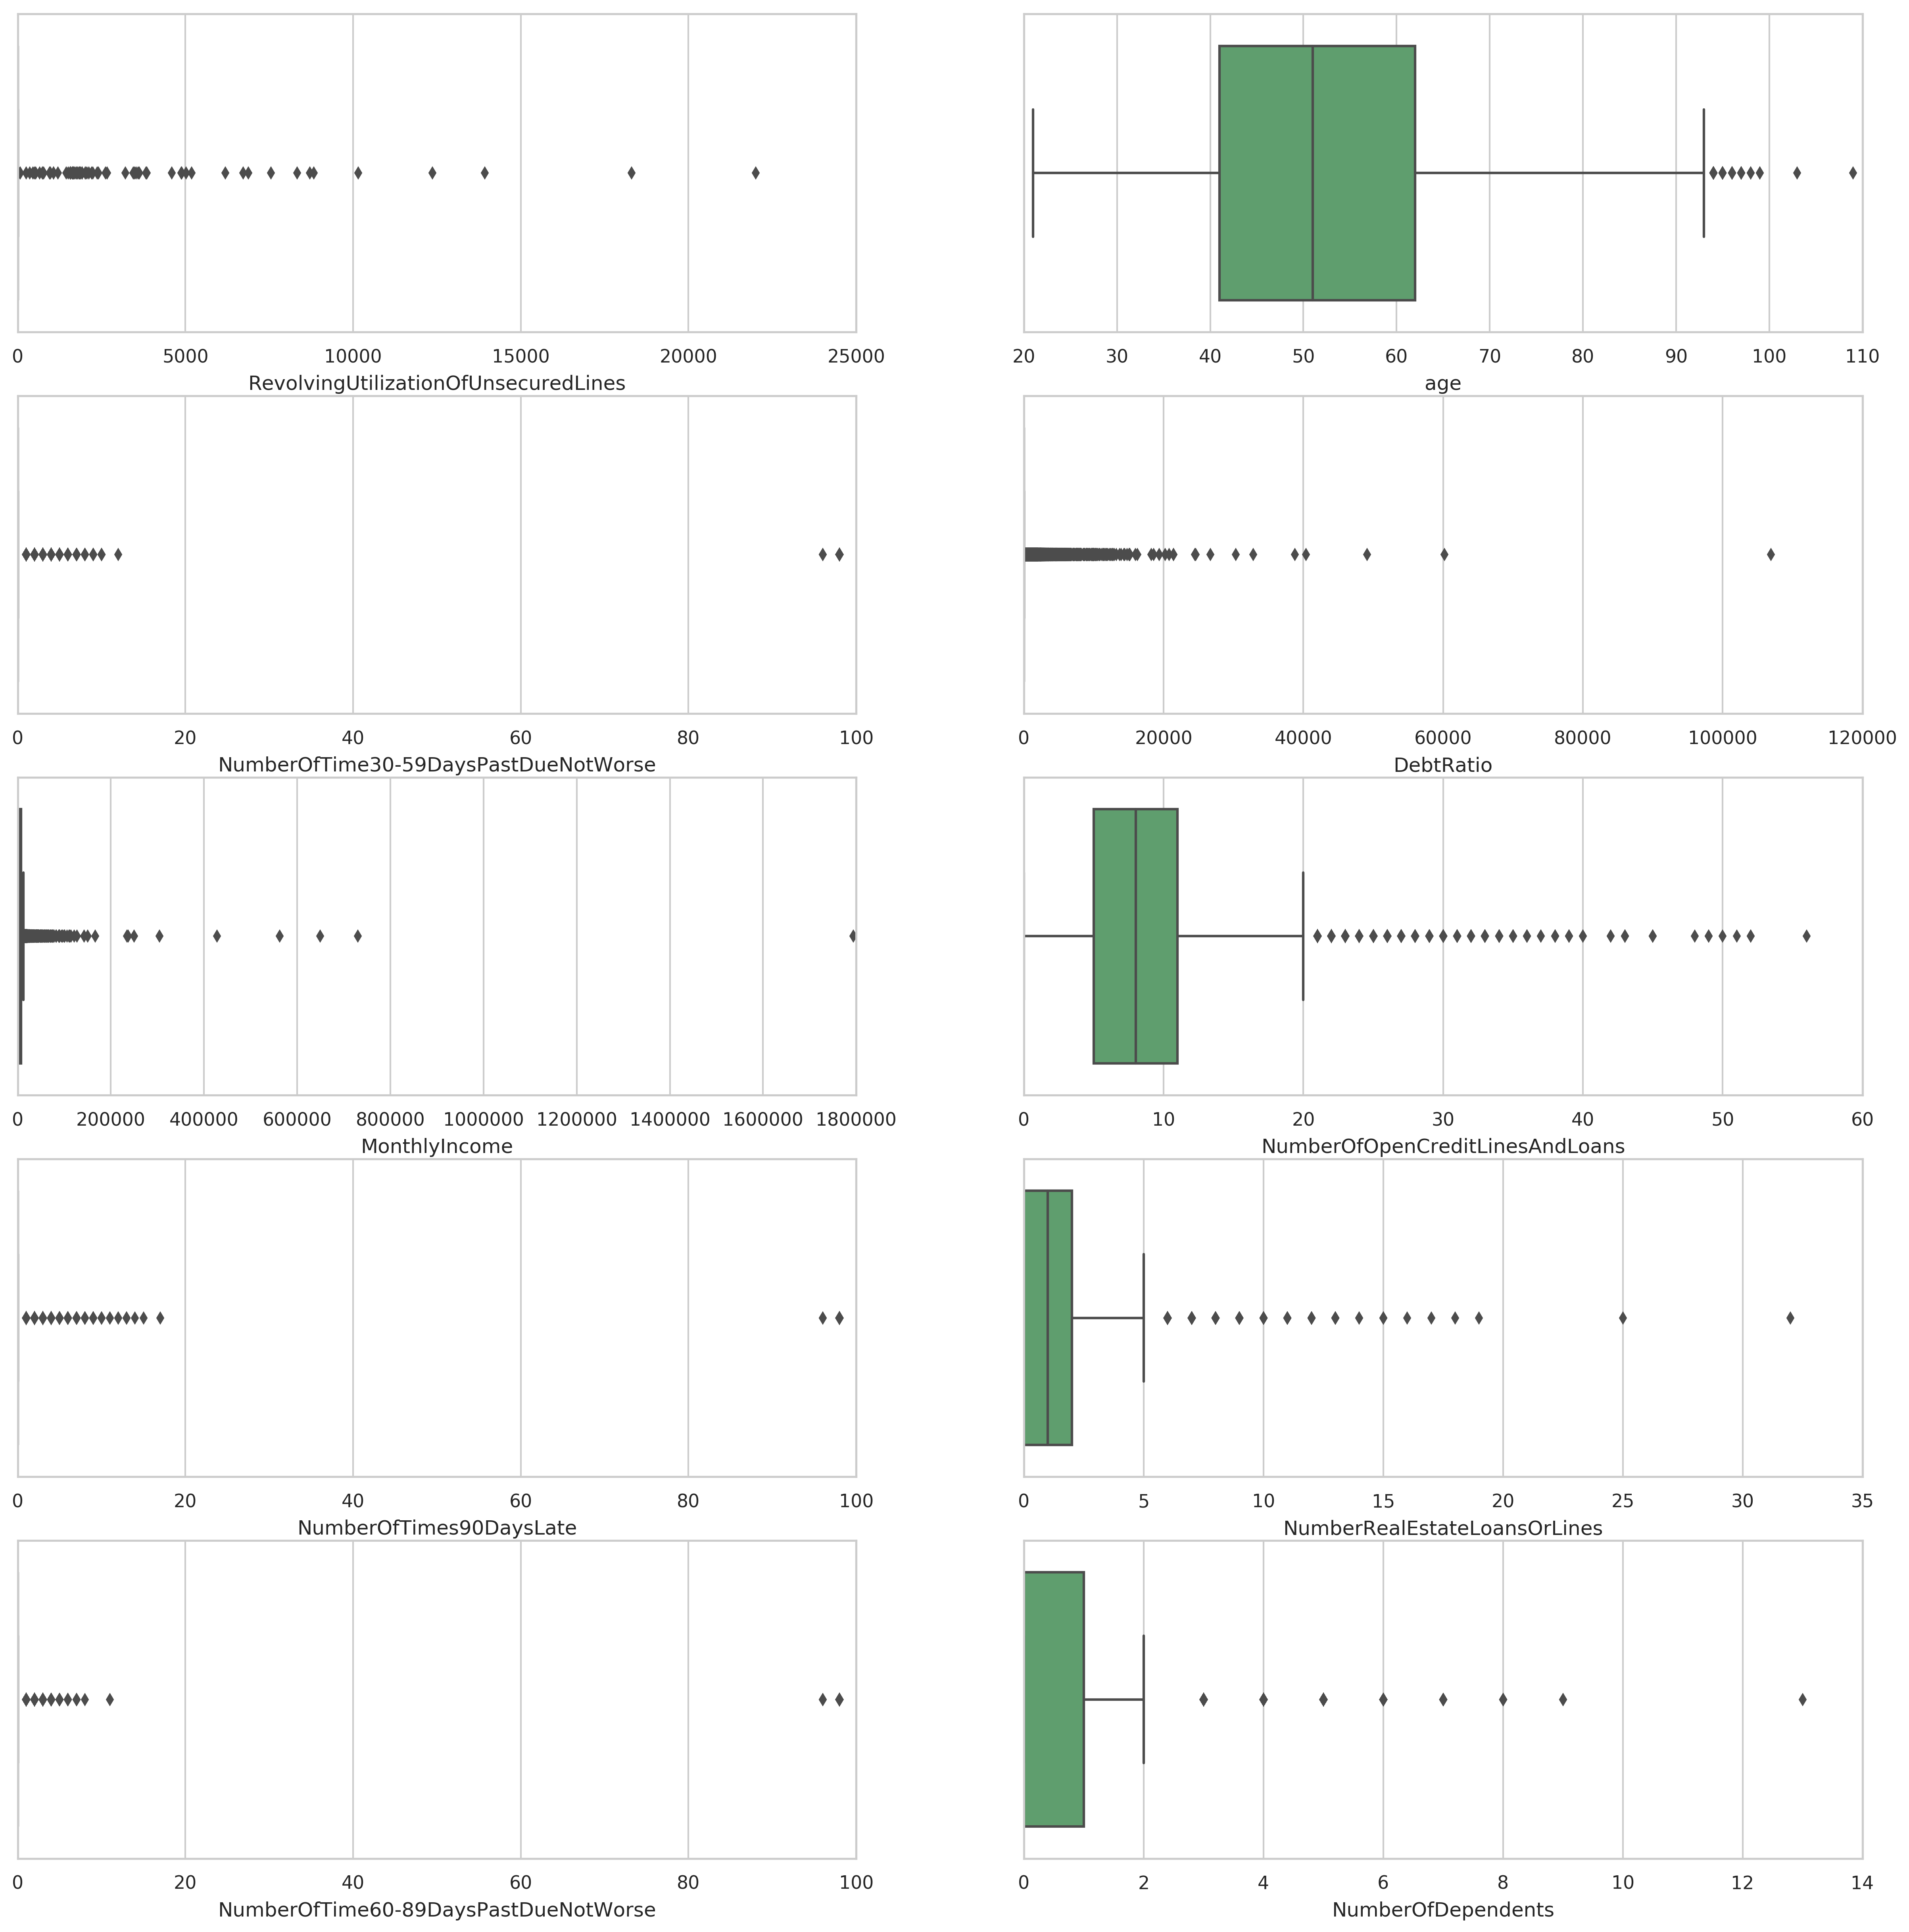

In [197]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
explore.box_plot(numeric)

> Giving the plot above, we could find that there exists some outliers in the data, and it would be useful to filter out all these outliers and see the distribution of the data. The following function for distribution used the data between the 0.05 quantile and 0.95 quantile.   
   
> It should be noted that, the model later on does not use the filtered data, rather, it keeps the outliers. I do so as I believe there need a deeper analysis into outliers which I will save for later study.

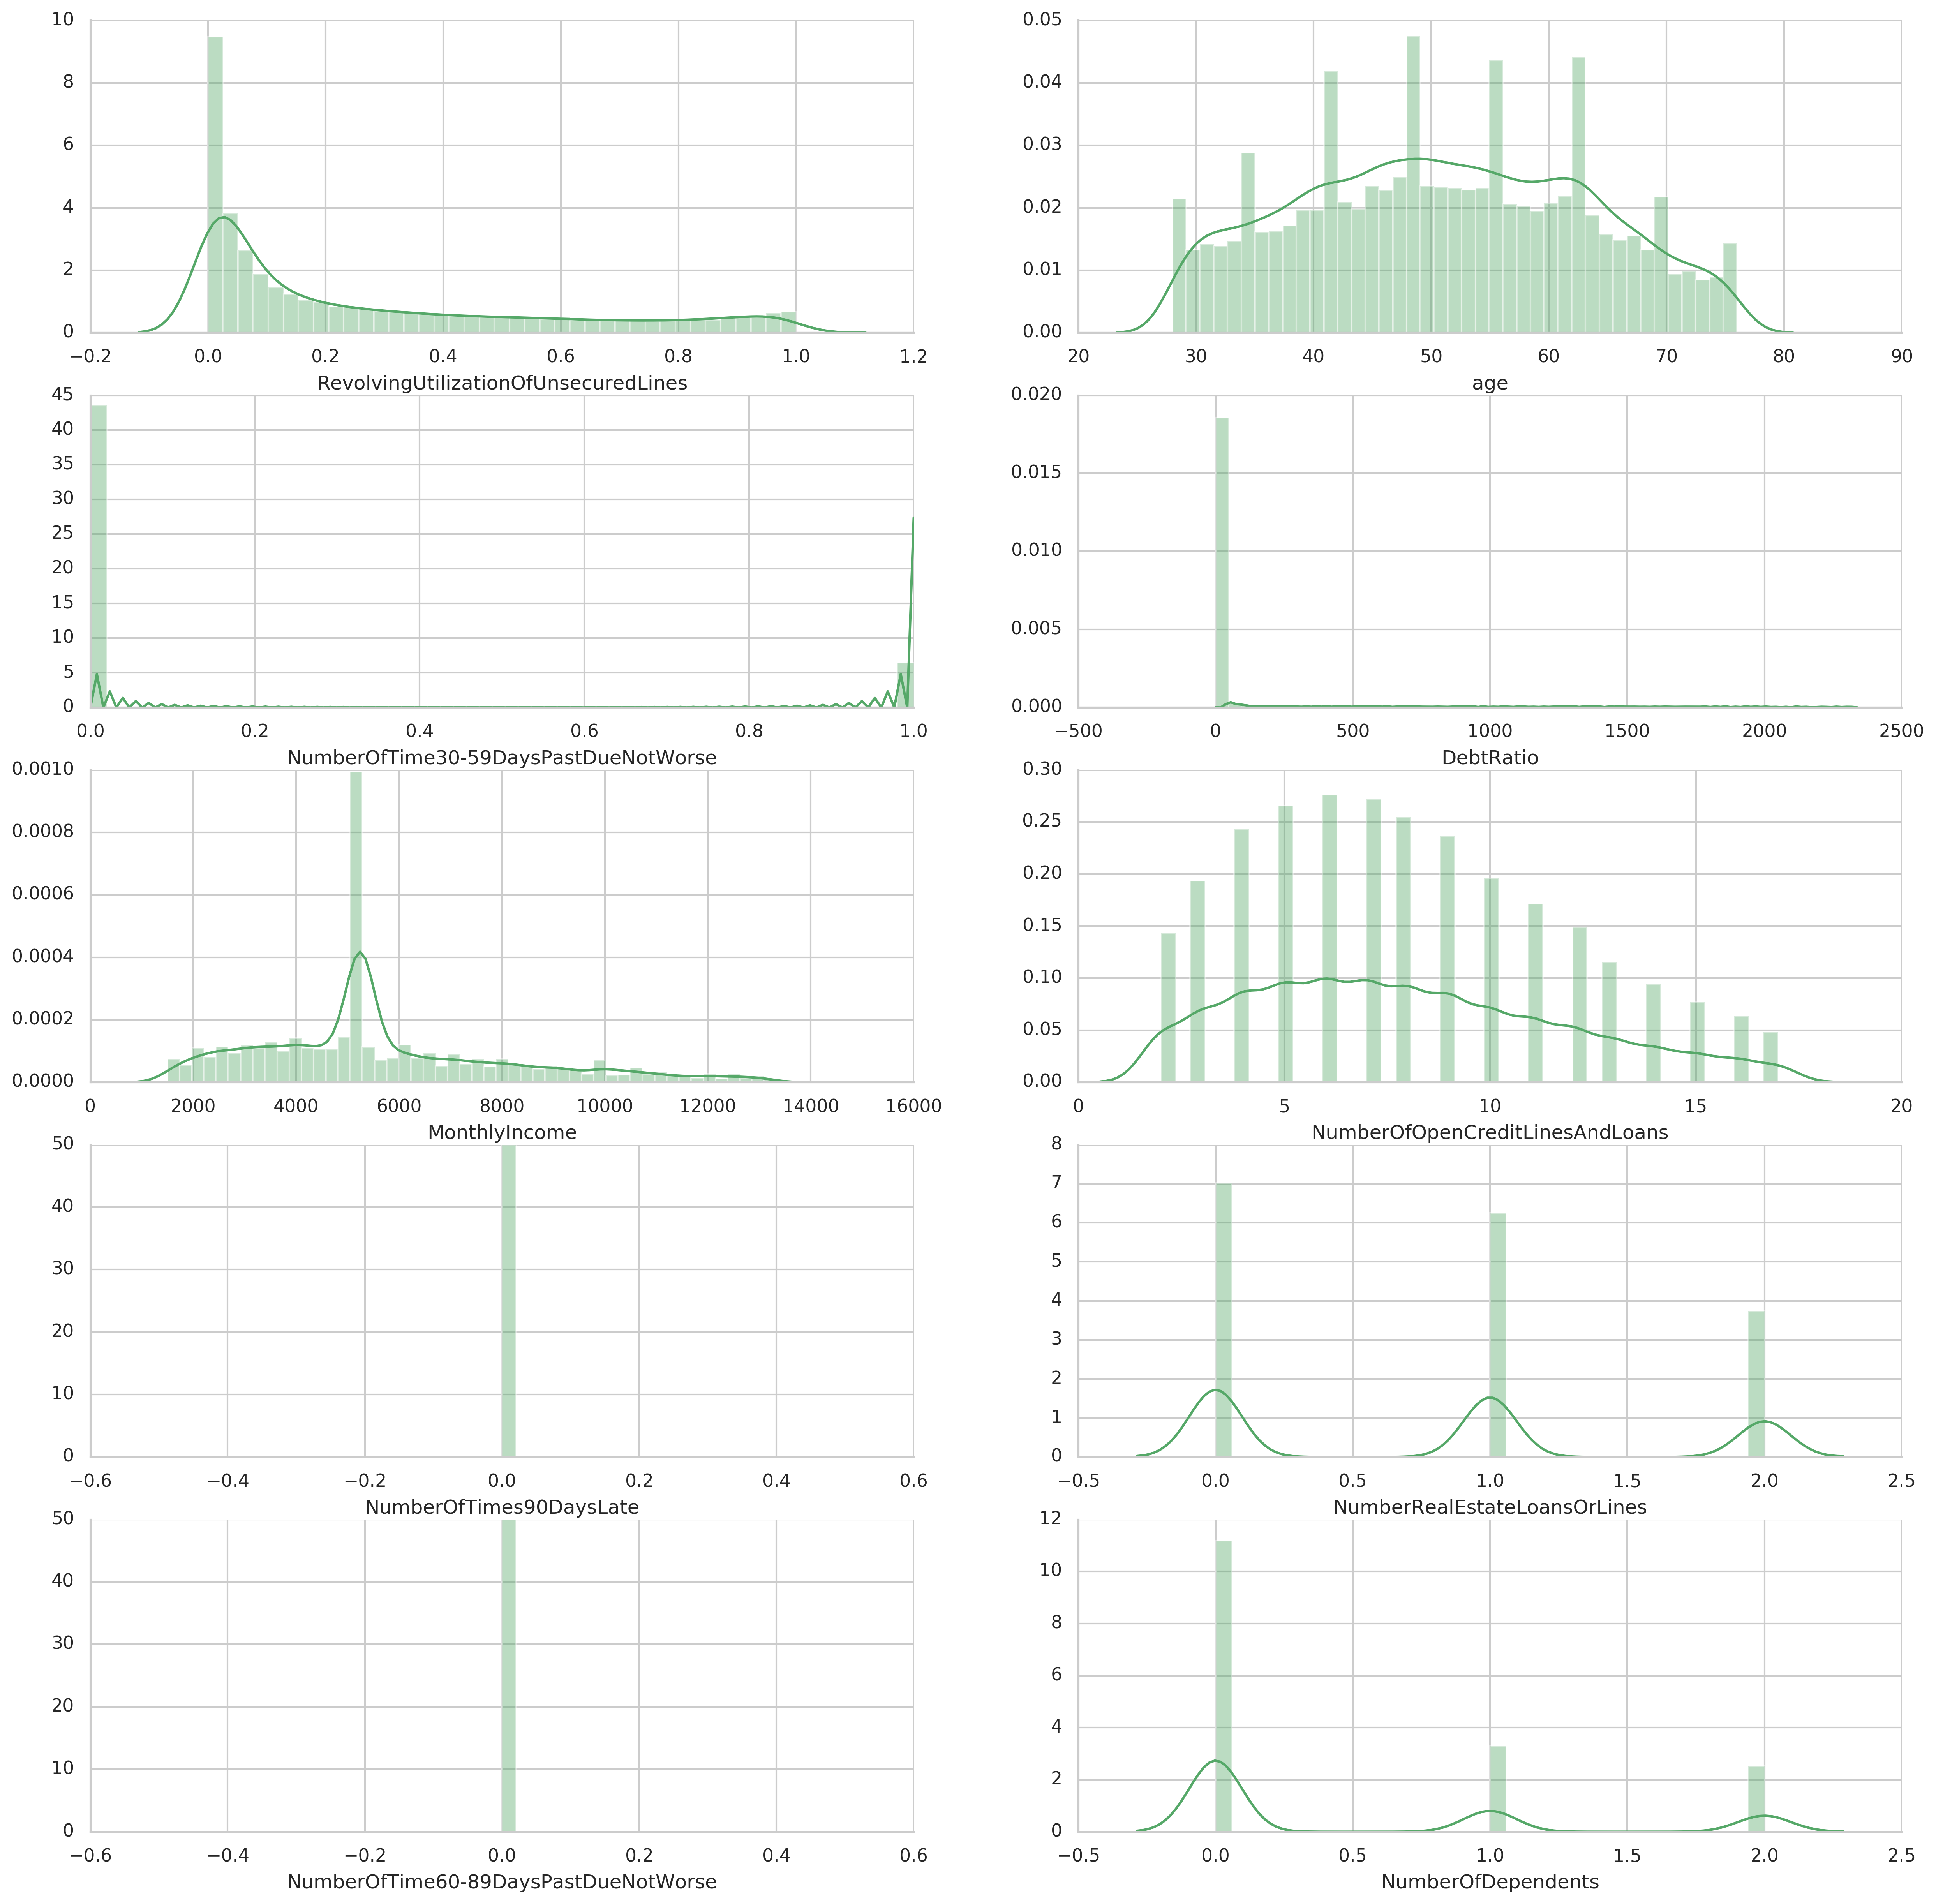

In [196]:
explore.dist_plot(numeric)

### 2.4 Check the Correlation Matrix of Numeric Columns

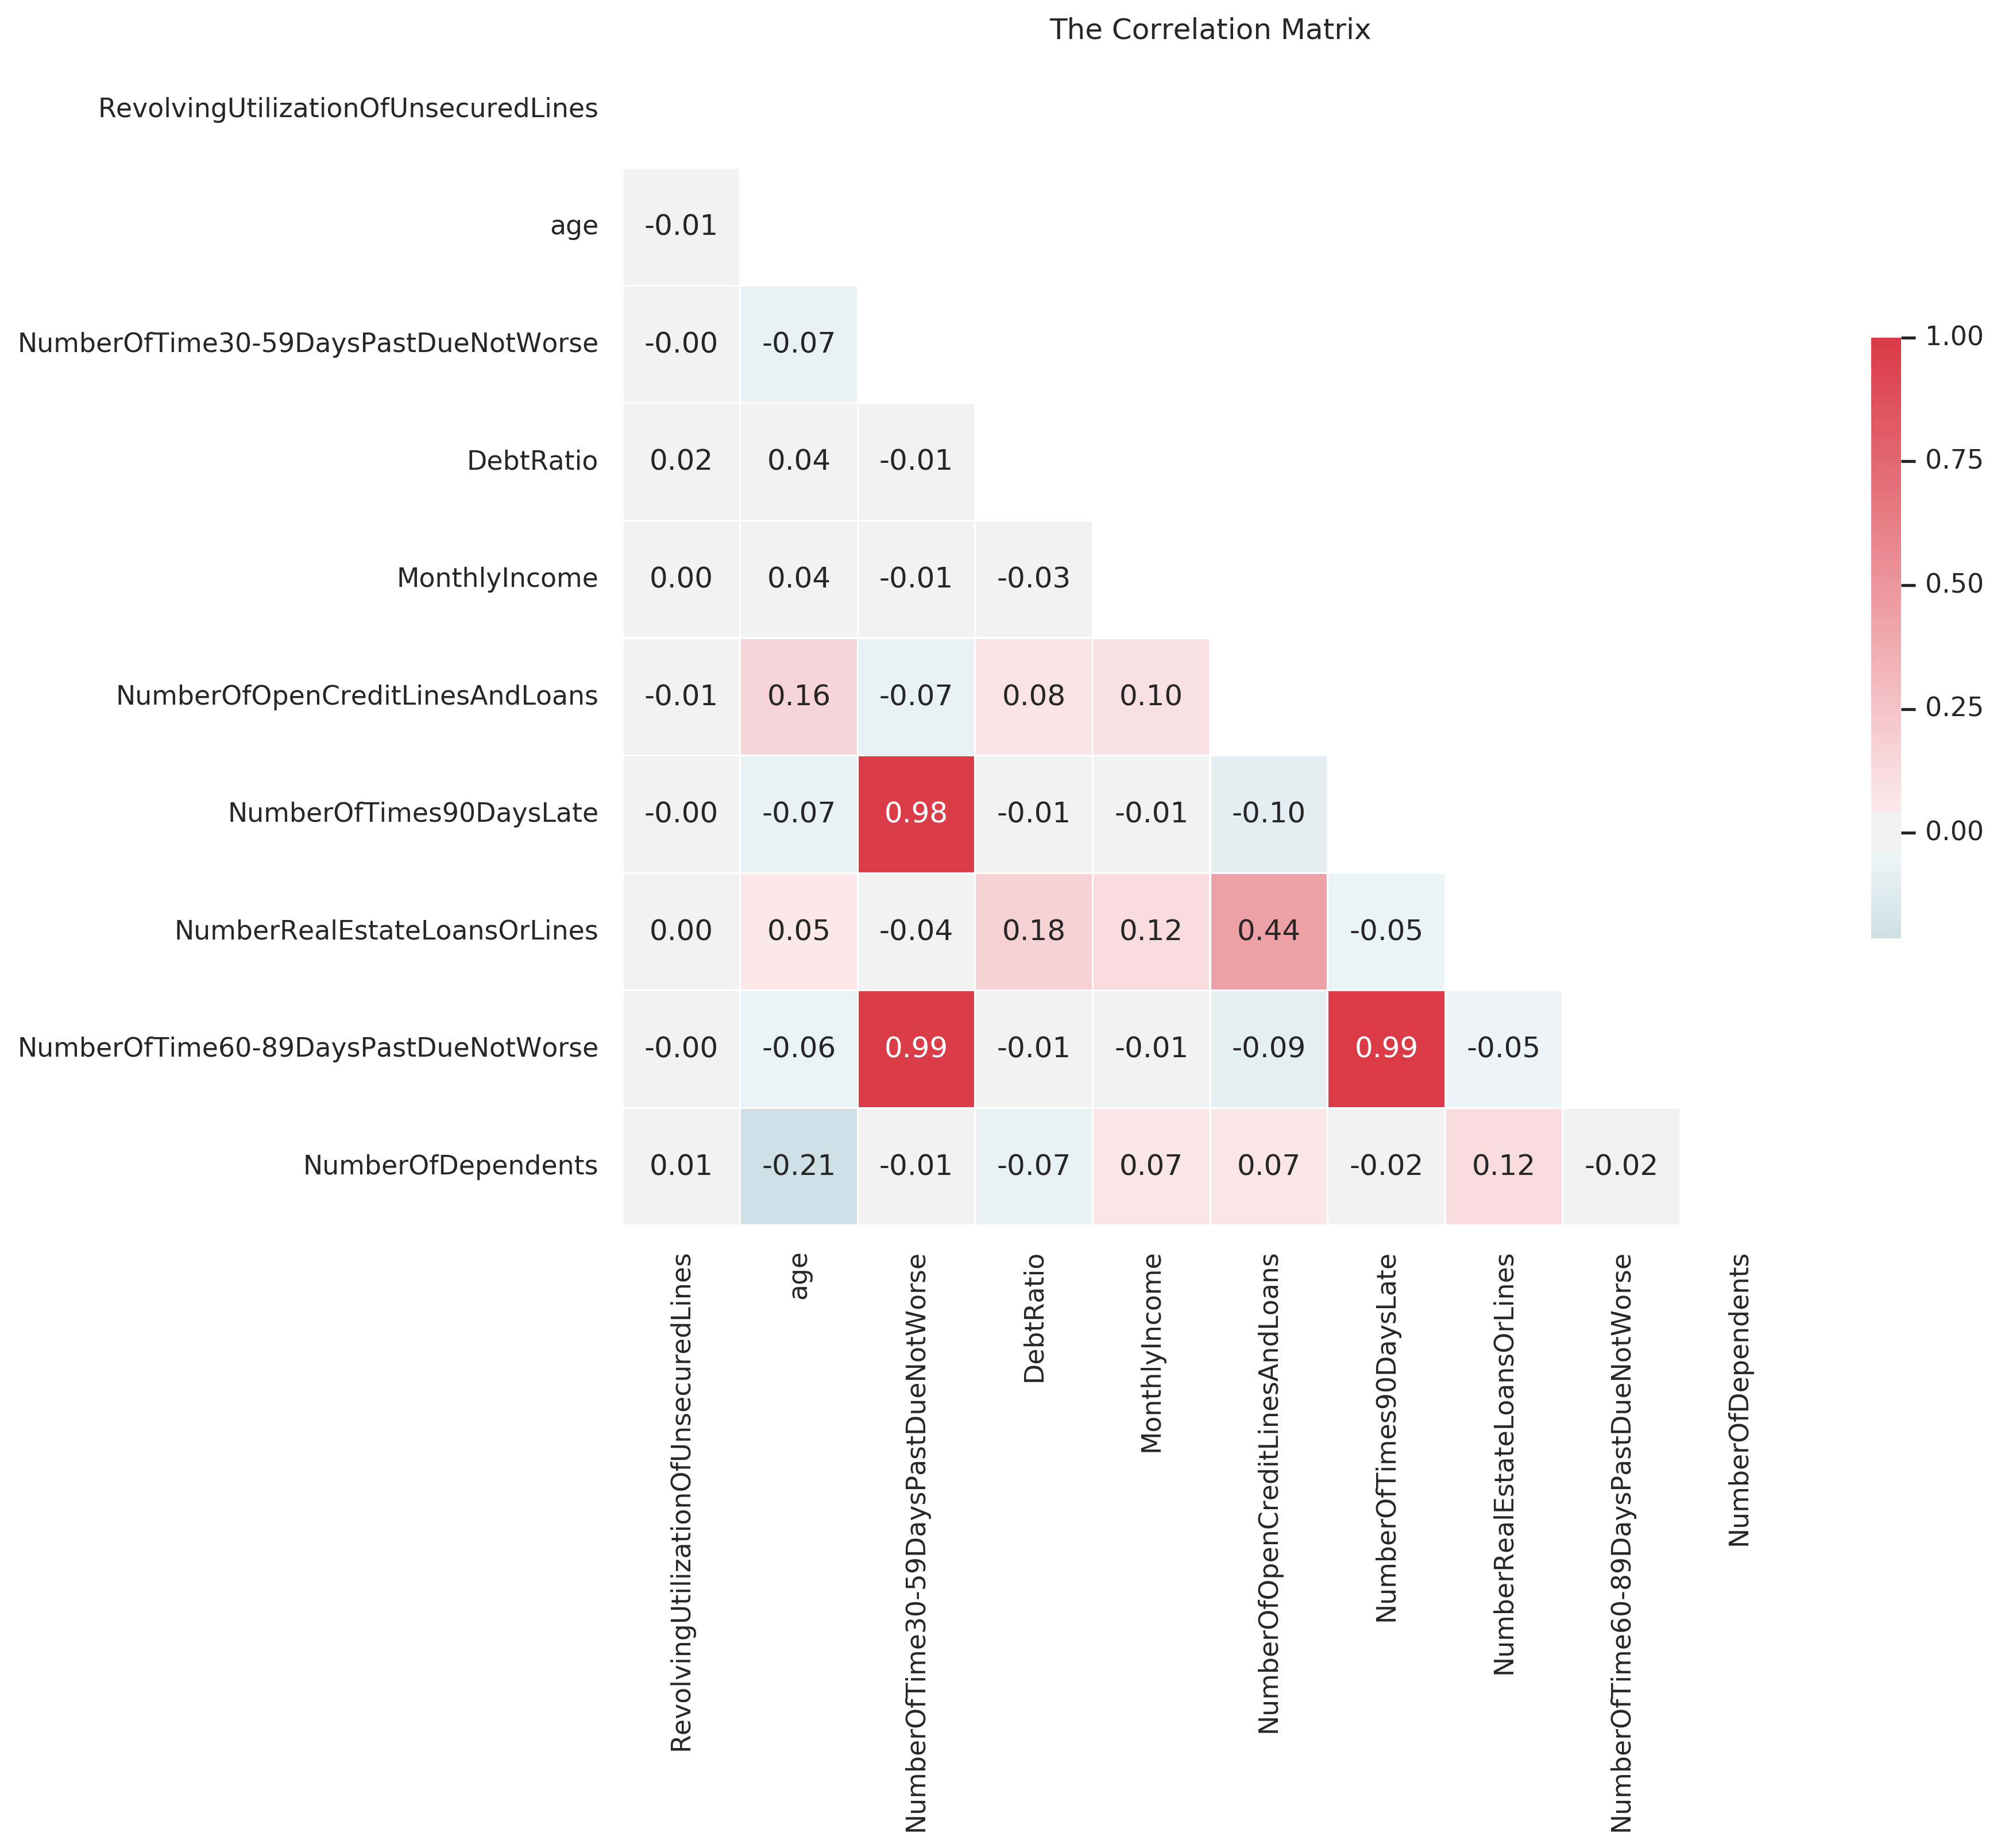

In [195]:
explore.corr_plot(numeric)

### 2.5 Drop Some Features with High Correlations

> The above correlation matrix shows that the following pairs have pretty high correlation with each other:
- `Number of Time 60-89 Days Past Due Not Worse` and `Number of Time 90 Days Late`
- `Number of Time 60-89 Days Past Due Not Worse` and `Number of Time 30-59 Days Past Due Not Worse` 
- `Number of Time 30-59 Days Past Due Not Worse` and `Number of Time 90 Days Late`  
  
> In this case, we could consider drop some of these variables to make sure our data has less redundancy. We could simply drop `Number Of Time 30-59 Days Past Due Not Worse`, `Number of Time 60-89 Days Past Due Not Worse`, and retain `Number of Time 90 Days Late` in our data.

In [230]:
col_names = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']
df = drop_redundancy(df, col_names)
target, features = prep.target_features_split(target_name, df)
cat, numeric = prep.num_cat_split(features, cat_list)

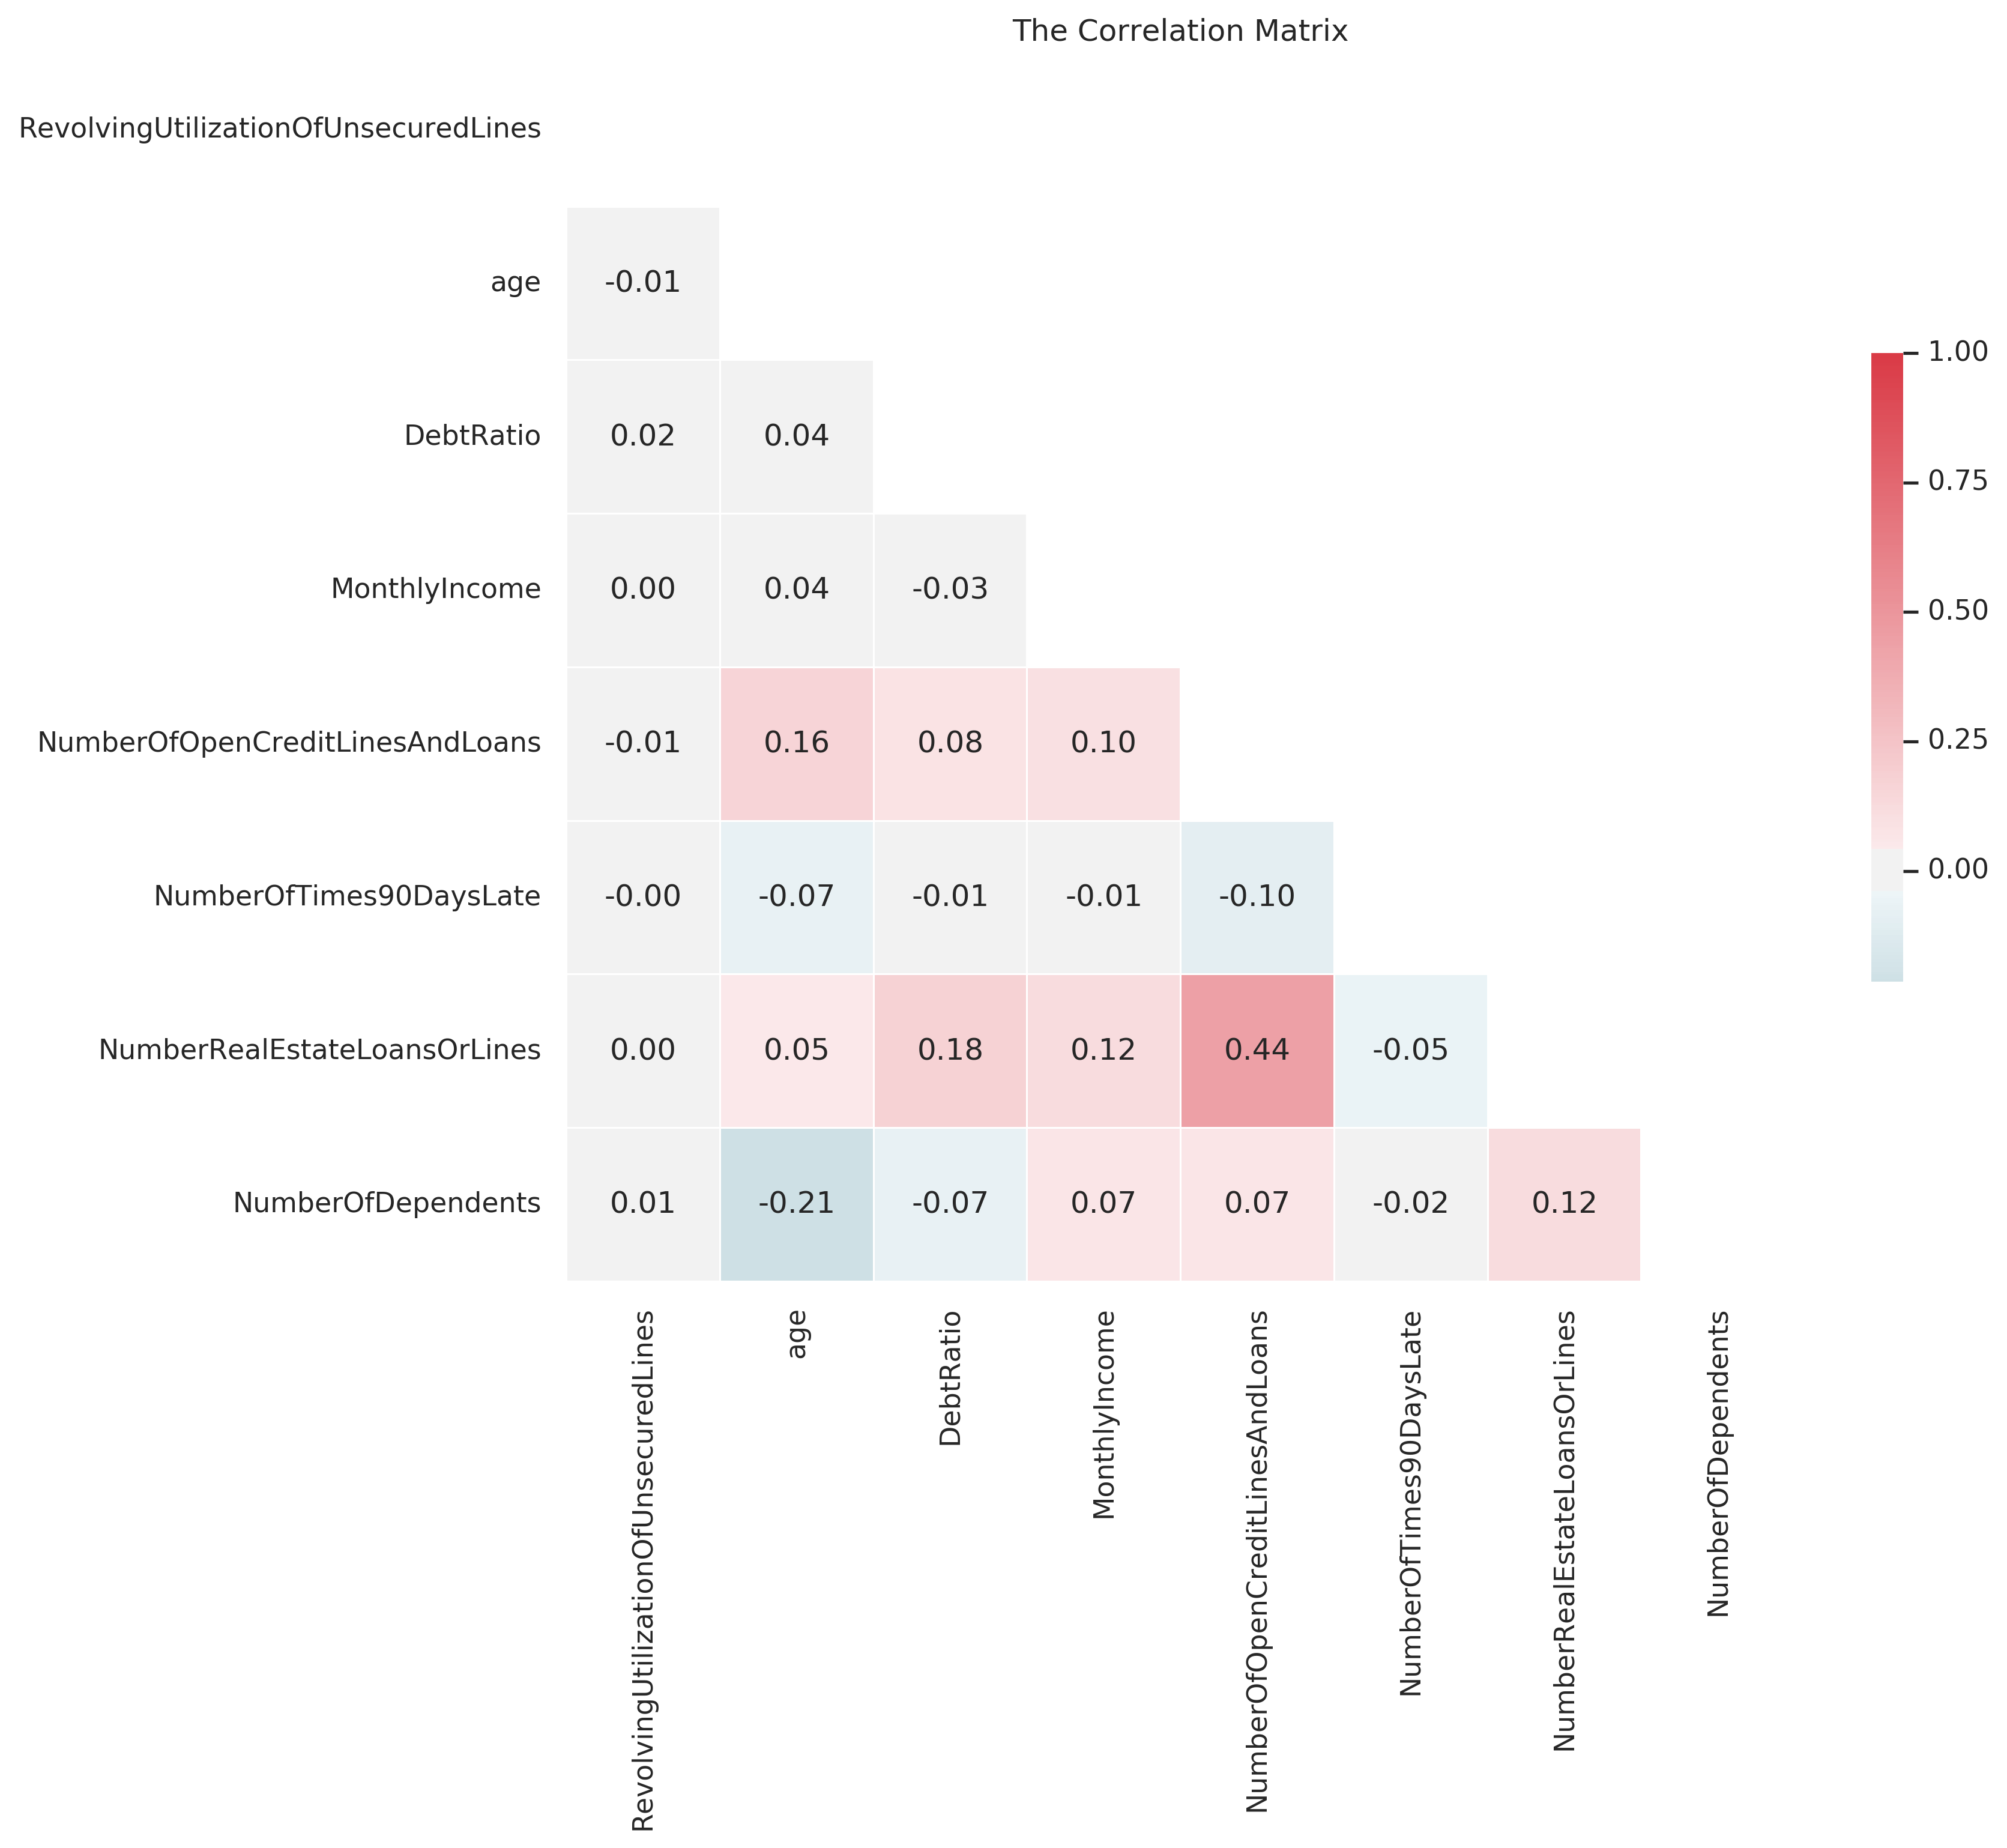

In [219]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
explore.corr_plot(numeric)

### 2.6 Draw Pair Plot for Features and Check the Possibility for a Machine Learning Method

In [238]:
temp = list(features.columns)
temp.append(target_name)
sorted_data = df[temp]
explore.pair_plot(sorted_data, target_name)

> From the plots, we can see that the two classes of the target value seem to be somewhat separated by some of the features, e.g. `Zip Code` and `Montly Income`.This implies the potential feasibility to use a machine learning algorithm to separate the data by label.

## Phase 3: Feature Engineering

### 3.0 General Inspection

In [390]:
import feature

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41016 entries, 0 to 41015
Data columns (total 11 columns):
PersonID                                41016 non-null int64
SeriousDlqin2yrs                        41016 non-null int64
RevolvingUtilizationOfUnsecuredLines    41016 non-null float64
age                                     41016 non-null int64
zipcode                                 41016 non-null object
DebtRatio                               41016 non-null float64
MonthlyIncome                           41016 non-null float64
NumberOfOpenCreditLinesAndLoans         41016 non-null int64
NumberOfTimes90DaysLate                 41016 non-null int64
NumberRealEstateLoansOrLines            41016 non-null int64
NumberOfDependents                      41016 non-null int64
dtypes: float64(3), int64(7), object(1)
memory usage: 3.4+ MB


> From the information of our data, it may be useful to discretize `age` and `montly income`, and transform `zip code` into some combinations of dummies. Also, by common sense, `Person ID` should have nothing to do with the characteristics of a person, and thus should be directly dropped from the data.

In [385]:
df_cleaned = df.drop('PersonID', axis=1)

In [386]:
list_to_discrete = ['age', 'MonthlyIncome']
list_to_dummy = ['zipcode']

### 3.1 Cut Outliers for Certain Features

> Note that here I only cut the outliers for `Monthly Income`, and this would make the discretization more meaningful.

In [394]:
df_cleaned = cut_outliers(df_cleaned, 'MonthlyIncome')

### 3.2 Discretize Continuous Features

In [397]:
feature.discretize(df_cleaned, 5, list_to_discrete)

In [398]:
df_cleaned.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age zipcode  \
0                 0                              1.000000    1   60601   
1                 0                              0.547745    2   60601   
2                 0                              0.044280    1   60601   
3                 0                              0.914249    1   60601   
4                 0                              0.026599    1   60601   

    DebtRatio  MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
0  505.000000              0                                2   
1    0.459565              1                                7   
2    0.014520              0                                5   
3    0.794875              1                               12   
4    0.049966              1                                4   

   NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  NumberOfDependents  
0                        0                             0                   0  
1                        0                             2                   0  
2                        0                             0                   0  
3                        0                             3                   0  
4                        0                             0                   2

In [401]:
(df_cleaned.MonthlyIncome == 0).sum()

33526

In [400]:
(df_cleaned.MonthlyIncome == 4).sum()

52

> In addition, from the above comparing of montly income, we can smell a sense of how inequal it is.

### 3.3 Transform Categorical Features to Dummies

In [402]:
df_cleaned = one_hot_encoding(df_cleaned, list_to_dummy)

In [403]:
df_cleaned.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age   DebtRatio  \
0                 0                              1.000000    1  505.000000   
1                 0                              0.547745    2    0.459565   
2                 0                              0.044280    1    0.014520   
3                 0                              0.914249    1    0.794875   
4                 0                              0.026599    1    0.049966   

   MonthlyIncome  NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0              0                                2                        0   
1              1                                7                        0   
2              0                                5                        0   
3              1                               12                        0   
4              1                                4                        0   

   NumberRealEstateLoansOrLines  NumberOfDependents  zipcode_60601  \
0                             0                   0              1   
1                             2                   0              1   
2                             0                   0              1   
3                             3                   0              1   
4                             0                   2              1   

   zipcode_60618  zipcode_60625  zipcode_60629  zipcode_60637  zipcode_60644  
0              0              0              0              0              0  
1              0              0              0              0              0  
2              0              0              0              0              0  
3              0              0              0              0              0  
4              0              0              0              0              0

## Phase 4: Model Training

## Phase 5: Model Evaluation